In [3]:
# [Cell 1: Imports, Environment Setup, and Initial Print Statements]
"""
This cell imports all necessary libraries, sets up the environment for plotting, and prints out initial messages.
We will use NumPy for numerical operations, matplotlib and seaborn for plotting, and scikit-learn for Gaussian Process Regression.
"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import copy

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Set plotting style for consistency
sns.set(style="whitegrid", context="notebook")

# Import Gaussian Process tools from scikit-learn
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, DotProduct, WhiteKernel, ConstantKernel as C

# For Bayesian inference plotting, we import additional utilities
import scipy.stats as stats

# Print the initial setup confirmation
print("Gaussian Processes: Environment setup complete.")
print("This notebook will demonstrate various kernels, uncertainty measurement, and Bayesian inference aspects using Gaussian Processes.")

Gaussian Processes: Environment setup complete.
This notebook will demonstrate various kernels, uncertainty measurement, and Bayesian inference aspects using Gaussian Processes.


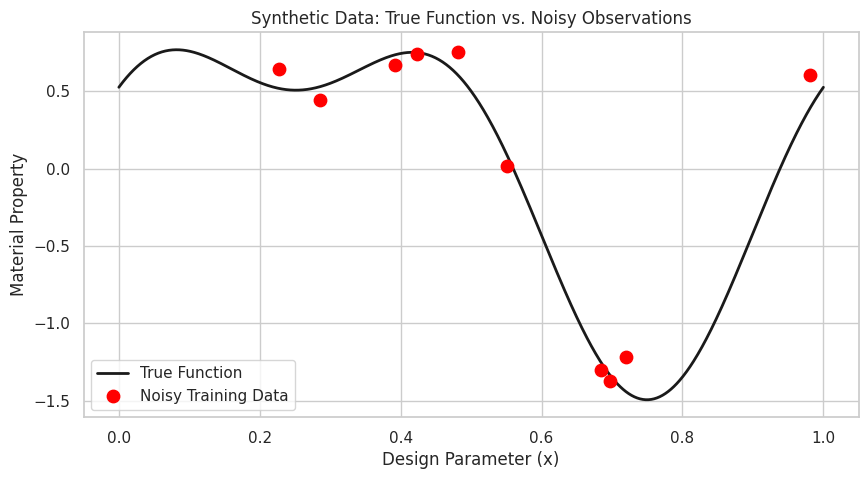

Synthetic training data generated and plotted.
Number of training points:  10


In [4]:
# [Cell 2: Generate Synthetic Data for Demonstration]
"""
We create a synthetic dataset to mimic a real-world scenario.
In materials science, this could represent experimental measurements of a material property (e.g., thermal conductivity) versus a design parameter.
Here, we generate noisy data from a known function for demonstration purposes.
"""

# Define the true underlying function (non-linear and oscillatory behavior)
def true_function(x):
    """
    True function to simulate the underlying behavior of a material property.
    It combines sinusoidal behavior and polynomial trends.
    """
    return np.sin(2 * np.pi * x) + 0.5 * np.cos(4 * np.pi * x) + 0.1 * (x - 0.5)**2

# Create a dense grid for plotting the true function
x_dense = np.linspace(0, 1, 1000)
y_dense = true_function(x_dense)

# Generate training data: we sample a few random points and add Gaussian noise to simulate experimental errors.
np.random.seed(123)
n_train = 10
X_train = np.sort(np.random.rand(n_train))
Y_train = true_function(X_train) + np.random.normal(0, 0.1, n_train)

# Plot the true function along with the noisy training data
plt.figure(figsize=(10, 5))
plt.plot(x_dense, y_dense, 'k-', label="True Function", linewidth=2)
plt.scatter(X_train, Y_train, c='red', s=80, label="Noisy Training Data", zorder=5)
plt.xlabel("Design Parameter (x)")
plt.ylabel("Material Property")
plt.title("Synthetic Data: True Function vs. Noisy Observations")
plt.legend()
plt.show()

print("Synthetic training data generated and plotted.")
print("Number of training points: ", n_train)

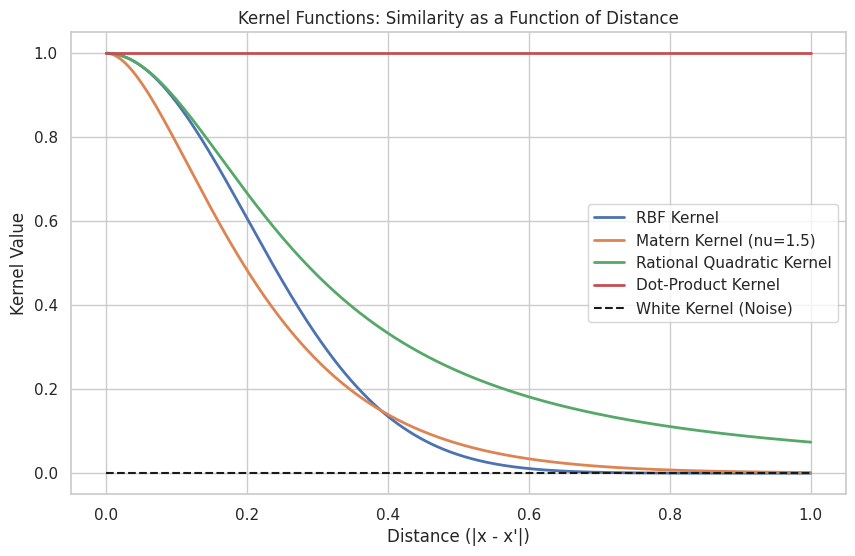

Kernel functions defined and visualized.
Observe how each kernel decays with distance, reflecting different assumptions on smoothness.


In [5]:
# [Cell 3: Exploring Different Kernel Functions – Definition and Visualization]
"""
In this cell, we define several kernel functions available in Gaussian Process Regression.
We then visualize how these kernels behave as a function of distance between points.
Understanding these kernels is critical because they encode our assumptions about smoothness and similarity in the input space.
"""

# Define several kernels with example hyperparameters
kernel_rbf = C(1.0, (1e-3, 1e3)) * RBF(length_scale=0.2)
kernel_matern = C(1.0, (1e-3, 1e3)) * Matern(length_scale=0.2, nu=1.5)
kernel_rq = C(1.0, (1e-3, 1e3)) * RationalQuadratic(length_scale=0.2, alpha=1.0)
kernel_dot = C(1.0, (1e-3, 1e3)) * DotProduct(sigma_0=1.0)
kernel_white = WhiteKernel(noise_level=0.1)

# Create a vector of distances
dists = np.linspace(0, 1, 500)

# Compute kernel values for each kernel as a function of distance (for isotropic kernels, kernel(x,x') = k(|x - x'|))
def plot_kernel(kernel, label):
    # For the RBF, Matern, and RationalQuadratic, the kernel function depends only on the distance.
    # We will compute k(0, r) for r in dists.
    # For DotProduct, the interpretation is different, so we adjust accordingly.
    k_vals = []
    for r in dists:
        # We evaluate the kernel between two points separated by distance r
        k_vals.append(kernel(np.array([[0]]), np.array([[r]]))[0, 0])
    plt.plot(dists, k_vals, label=label, linewidth=2)

plt.figure(figsize=(10, 6))
plot_kernel(kernel_rbf, "RBF Kernel")
plot_kernel(kernel_matern, "Matern Kernel (nu=1.5)")
plot_kernel(kernel_rq, "Rational Quadratic Kernel")
plot_kernel(kernel_dot, "Dot-Product Kernel")
plt.plot(dists, [kernel_white(np.array([[0]]), np.array([[r]]))[0, 0] for r in dists],
         'k--', label="White Kernel (Noise)")
plt.xlabel("Distance (|x - x'|)")
plt.ylabel("Kernel Value")
plt.title("Kernel Functions: Similarity as a Function of Distance")
plt.legend()
plt.show()

print("Kernel functions defined and visualized.")
print("Observe how each kernel decays with distance, reflecting different assumptions on smoothness.")

Optimized kernel parameters (RBF): 0.965**2 * RBF(length_scale=0.13) + WhiteKernel(noise_level=0.00274)


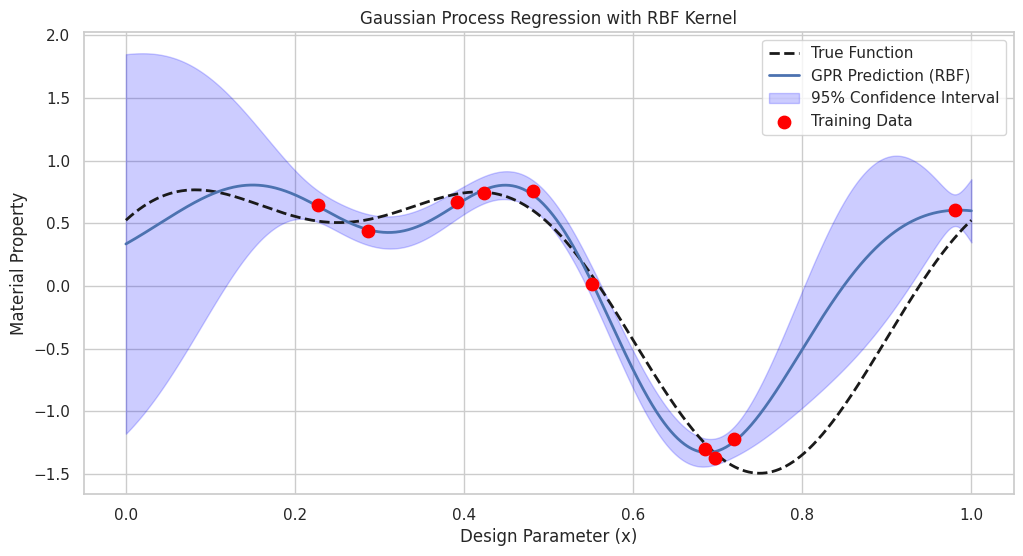

In [6]:
# [Cell 4: Fitting Gaussian Process with RBF Kernel]
"""
Now, we fit a Gaussian Process Regression (GPR) model using an RBF kernel.
We then plot the GP predictions, the 95% confidence interval (2 standard deviations), and the training data.
This cell demonstrates the core idea of GPR: predictions with uncertainty.
"""

# Define a GPR model using the RBF kernel (with constant kernel multiplier)
gpr_rbf = GaussianProcessRegressor(kernel=kernel_rbf + kernel_white, n_restarts_optimizer=10, normalize_y=True)

# Reshape training data for scikit-learn (requires 2D arrays for X)
X_train_2d = X_train.reshape(-1, 1)

# Fit the model
gpr_rbf.fit(X_train_2d, Y_train)
print("Optimized kernel parameters (RBF):", gpr_rbf.kernel_)

# Predict on a dense grid
X_dense = x_dense.reshape(-1, 1)
y_pred, y_std = gpr_rbf.predict(X_dense, return_std=True)

# Plot predictions with confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(x_dense, y_dense, 'k--', label="True Function", linewidth=2)
plt.plot(x_dense, y_pred, 'b-', label="GPR Prediction (RBF)", linewidth=2)
plt.fill_between(x_dense.ravel(), y_pred - 1.96*y_std, y_pred + 1.96*y_std, color='blue', alpha=0.2, label="95% Confidence Interval")
plt.scatter(X_train, Y_train, c='red', s=80, label="Training Data", zorder=5)
plt.xlabel("Design Parameter (x)")
plt.ylabel("Material Property")
plt.title("Gaussian Process Regression with RBF Kernel")
plt.legend()
plt.show()

Optimized kernel parameters (Matern): 0.923**2 * Matern(length_scale=0.181, nu=1.5) + WhiteKernel(noise_level=0.00247)


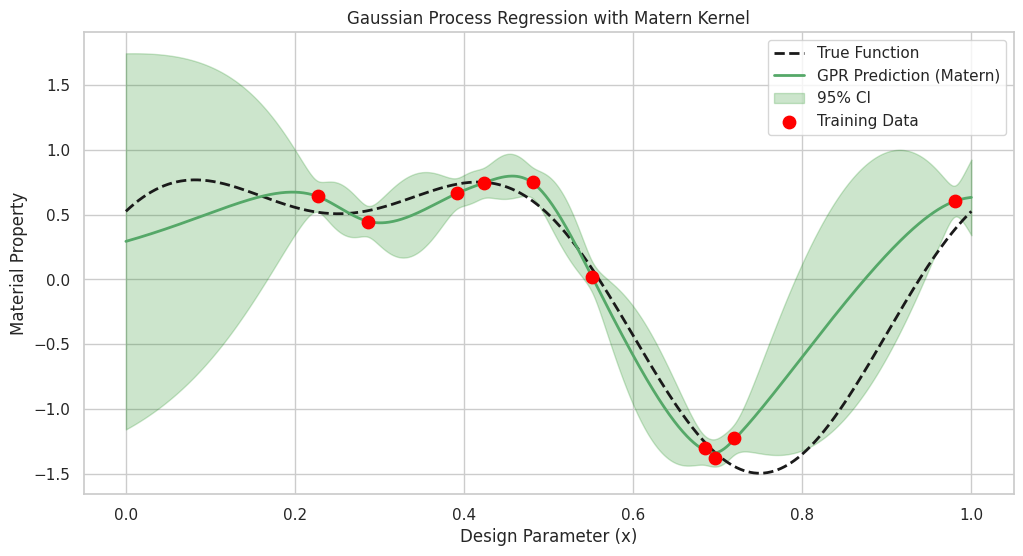

In [7]:
# [Cell 5: Fitting Gaussian Process with Matern Kernel]
"""
We repeat the fitting procedure using the Matern kernel.
The Matern kernel is often preferred when the underlying function is expected to be less smooth than that assumed by the RBF kernel.
We then compare the predictive mean and uncertainty with the previous model.
"""

gpr_matern = GaussianProcessRegressor(kernel=kernel_matern + kernel_white, n_restarts_optimizer=10, normalize_y=True)
gpr_matern.fit(X_train_2d, Y_train)
print("Optimized kernel parameters (Matern):", gpr_matern.kernel_)

y_pred_matern, y_std_matern = gpr_matern.predict(X_dense, return_std=True)

plt.figure(figsize=(12, 6))
plt.plot(x_dense, y_dense, 'k--', label="True Function", linewidth=2)
plt.plot(x_dense, y_pred_matern, 'g-', label="GPR Prediction (Matern)", linewidth=2)
plt.fill_between(x_dense.ravel(), y_pred_matern - 1.96*y_std_matern, y_pred_matern + 1.96*y_std_matern, color='green', alpha=0.2, label="95% CI")
plt.scatter(X_train, Y_train, c='red', s=80, label="Training Data", zorder=5)
plt.xlabel("Design Parameter (x)")
plt.ylabel("Material Property")
plt.title("Gaussian Process Regression with Matern Kernel")
plt.legend()
plt.show()


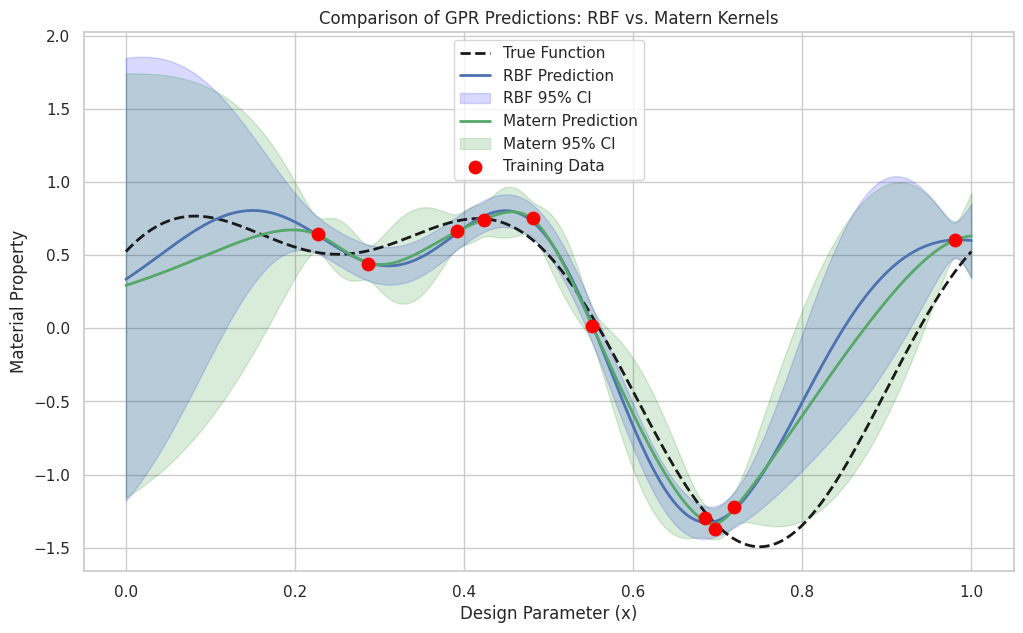

Comparison of RBF and Matern kernels completed.
Observe differences in the width of confidence intervals and slight variations in predictions.


In [8]:
# [Cell 6: Comparing Predictions and Uncertainty Between Kernels]
"""
In this cell, we compare the predictions and uncertainties obtained using the RBF and Matern kernels.
We plot the predictions from both models on the same graph, along with their confidence intervals, to highlight differences.
"""

plt.figure(figsize=(12, 7))
plt.plot(x_dense, y_dense, 'k--', label="True Function", linewidth=2)
plt.plot(x_dense, y_pred, 'b-', label="RBF Prediction", linewidth=2)
plt.fill_between(x_dense.ravel(), y_pred - 1.96*y_std, y_pred + 1.96*y_std, color='blue', alpha=0.15, label="RBF 95% CI")
plt.plot(x_dense, y_pred_matern, 'g-', label="Matern Prediction", linewidth=2)
plt.fill_between(x_dense.ravel(), y_pred_matern - 1.96*y_std_matern, y_pred_matern + 1.96*y_std_matern, color='green', alpha=0.15, label="Matern 95% CI")
plt.scatter(X_train, Y_train, c='red', s=80, label="Training Data", zorder=5)
plt.xlabel("Design Parameter (x)")
plt.ylabel("Material Property")
plt.title("Comparison of GPR Predictions: RBF vs. Matern Kernels")
plt.legend()
plt.show()

print("Comparison of RBF and Matern kernels completed.")
print("Observe differences in the width of confidence intervals and slight variations in predictions.")

Initial Log-Marginal Likelihood (RBF): -2.8049517514751896
Log-Marginal Likelihood after optimization (RBF): -2.8049517514751896
Optimized Kernel (RBF): 0.965**2 * RBF(length_scale=0.13) + WhiteKernel(noise_level=0.00274)


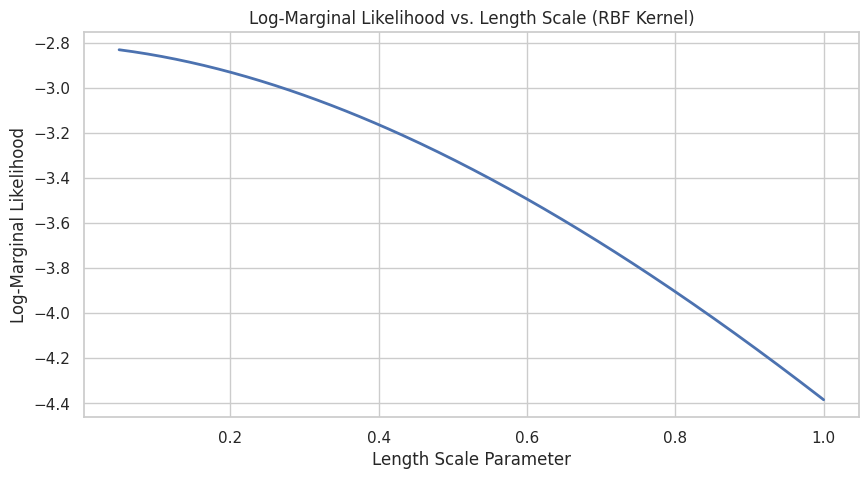

Bayesian inference via hyperparameter optimization has been visualized.
The LML plot shows how sensitive the model is to the kernel hyperparameter settings.


In [9]:
# [Cell 7: Demonstrating Bayesian Inference via Hyperparameter Optimization]
"""
Gaussian Process Regression inherently employs Bayesian inference.
In this cell, we inspect the Bayesian optimization of hyperparameters.
The model’s kernel parameters are optimized by maximizing the marginal likelihood.
We print the log-marginal likelihood values and optimized kernel parameters.
"""

# For the RBF kernel model, we retrieve the log-marginal likelihood (LML)
lml_initial = gpr_rbf.log_marginal_likelihood_value_
lml_after = gpr_rbf.log_marginal_likelihood(gpr_rbf.kernel_.theta)
print("Initial Log-Marginal Likelihood (RBF):", lml_initial)
print("Log-Marginal Likelihood after optimization (RBF):", lml_after)
print("Optimized Kernel (RBF):", gpr_rbf.kernel_)

# Plot the LML surface for one hyperparameter (length scale) while fixing others, to visualize the Bayesian inference process.
def plot_lml_surface(kernel, model, param_name='length_scale'):
    """
    Vary one hyperparameter over a range and plot the log-marginal likelihood.
    """
    theta_range = np.linspace(0.05, 1.0, 200)
    lml_values = []
    # Get a copy of current kernel parameters
    params = model.kernel_.theta.copy()
    # Identify index of the hyperparameter (assuming ordering in theta)
    # For simplicity, we assume length_scale is the first parameter in the kernel.
    for theta_val in theta_range:
        new_params = params.copy()
        new_params[0] = theta_val
        lml = model.log_marginal_likelihood(new_params)
        lml_values.append(lml)
    plt.figure(figsize=(10, 5))
    plt.plot(theta_range, lml_values, 'b-', linewidth=2)
    plt.xlabel("Length Scale Parameter")
    plt.ylabel("Log-Marginal Likelihood")
    plt.title("Log-Marginal Likelihood vs. Length Scale (RBF Kernel)")
    plt.grid(True)
    plt.show()

plot_lml_surface(kernel_rbf, gpr_rbf)

print("Bayesian inference via hyperparameter optimization has been visualized.")
print("The LML plot shows how sensitive the model is to the kernel hyperparameter settings.")

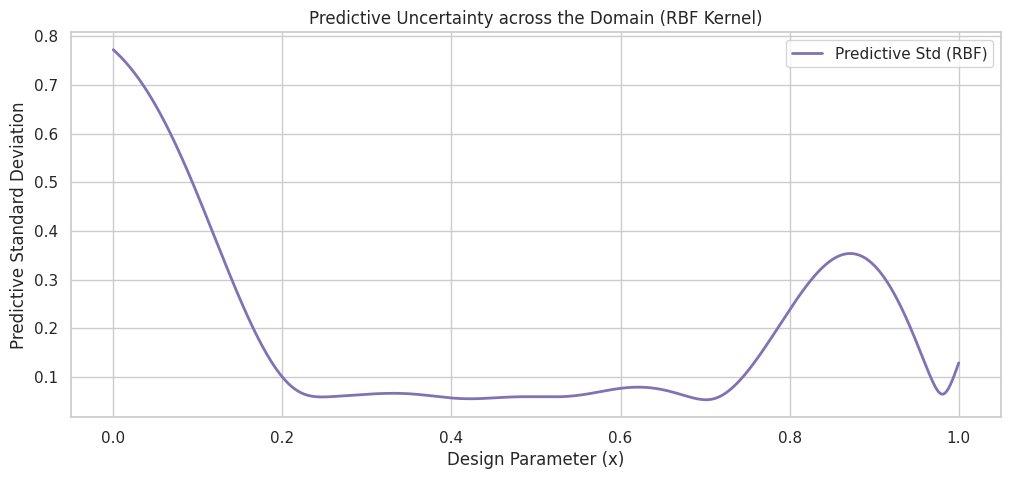

Predictive uncertainty statistics (RBF Kernel):
Mean Standard Deviation: 0.1863
Max Standard Deviation: 0.7723
Min Standard Deviation: 0.0530


In [10]:
# [Cell 8: Uncertainty Measurement – Detailed Analysis]
"""
In Gaussian Processes, uncertainty is quantified through the predictive variance.
This cell demonstrates how to extract and analyze the uncertainty estimates.
We plot the predictive mean and 95% confidence intervals, and we print out summary statistics of the uncertainties.
"""

# Compute the predictive standard deviation on the dense grid using the RBF model
_, y_std_rbf = gpr_rbf.predict(X_dense, return_std=True)

# Plot the predictive standard deviation
plt.figure(figsize=(12, 5))
plt.plot(x_dense, y_std_rbf, 'm-', linewidth=2, label="Predictive Std (RBF)")
plt.xlabel("Design Parameter (x)")
plt.ylabel("Predictive Standard Deviation")
plt.title("Predictive Uncertainty across the Domain (RBF Kernel)")
plt.legend()
plt.show()

# Summary statistics on uncertainty
print("Predictive uncertainty statistics (RBF Kernel):")
print("Mean Standard Deviation: {:.4f}".format(np.mean(y_std_rbf)))
print("Max Standard Deviation: {:.4f}".format(np.max(y_std_rbf)))
print("Min Standard Deviation: {:.4f}".format(np.min(y_std_rbf)))

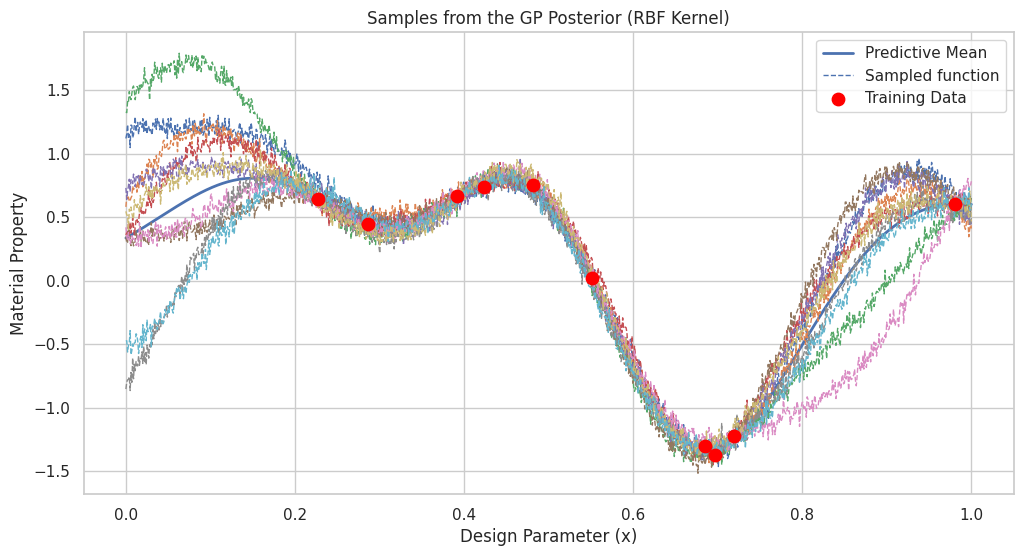

Posterior sampling complete. Samples illustrate the variability in plausible functions.


In [11]:
# [Cell 9: Sampling from the Posterior Distribution]
"""
One of the powerful features of Gaussian Processes is the ability to sample functions from the posterior distribution.
This cell demonstrates how to draw multiple samples from the GP posterior and plot them along with the predictive mean.
These samples represent plausible functions that are consistent with the observed data and the model uncertainty.
"""

n_samples = 10
samples = gpr_rbf.sample_y(X_dense, n_samples=n_samples, random_state=123)

plt.figure(figsize=(12, 6))
plt.plot(x_dense, y_pred, 'b-', label="Predictive Mean", linewidth=2)
for i in range(n_samples):
    plt.plot(x_dense, samples[:, i], lw=1, ls='--', label="Sampled function" if i == 0 else None)
plt.scatter(X_train, Y_train, c='red', s=80, label="Training Data", zorder=5)
plt.xlabel("Design Parameter (x)")
plt.ylabel("Material Property")
plt.title("Samples from the GP Posterior (RBF Kernel)")
plt.legend()
plt.show()

print("Posterior sampling complete. Samples illustrate the variability in plausible functions.")

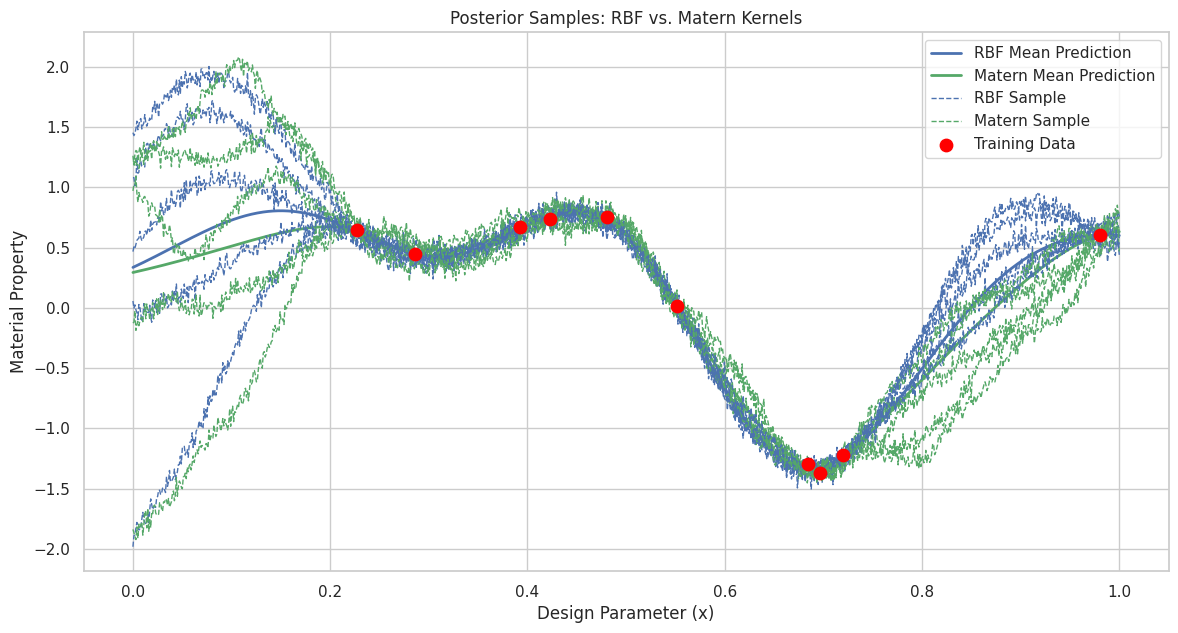

Posterior samples for both kernels plotted.
Notice the differences in the spread of samples indicating how kernel choice affects uncertainty.


In [12]:
# [Cell 10: Comparing Different Kernels – Posterior Samples and Uncertainty]
"""
In this cell, we sample from the posterior of both the RBF and Matern kernel models.
By comparing these samples, we gain insights into how the kernel choice affects the model's predictions and uncertainty.
We plot several samples from each model on a shared graph.
"""

samples_rbf = gpr_rbf.sample_y(X_dense, n_samples=5, random_state=101)
samples_matern = gpr_matern.sample_y(X_dense, n_samples=5, random_state=101)

plt.figure(figsize=(14, 7))
plt.plot(x_dense, y_pred, 'b-', label="RBF Mean Prediction", linewidth=2)
plt.plot(x_dense, y_pred_matern, 'g-', label="Matern Mean Prediction", linewidth=2)
for i in range(5):
    plt.plot(x_dense, samples_rbf[:, i], 'b--', lw=1, label="RBF Sample" if i == 0 else None)
    plt.plot(x_dense, samples_matern[:, i], 'g--', lw=1, label="Matern Sample" if i == 0 else None)
plt.scatter(X_train, Y_train, c='red', s=80, label="Training Data", zorder=5)
plt.xlabel("Design Parameter (x)")
plt.ylabel("Material Property")
plt.title("Posterior Samples: RBF vs. Matern Kernels")
plt.legend()
plt.show()

print("Posterior samples for both kernels plotted.")
print("Notice the differences in the spread of samples indicating how kernel choice affects uncertainty.")

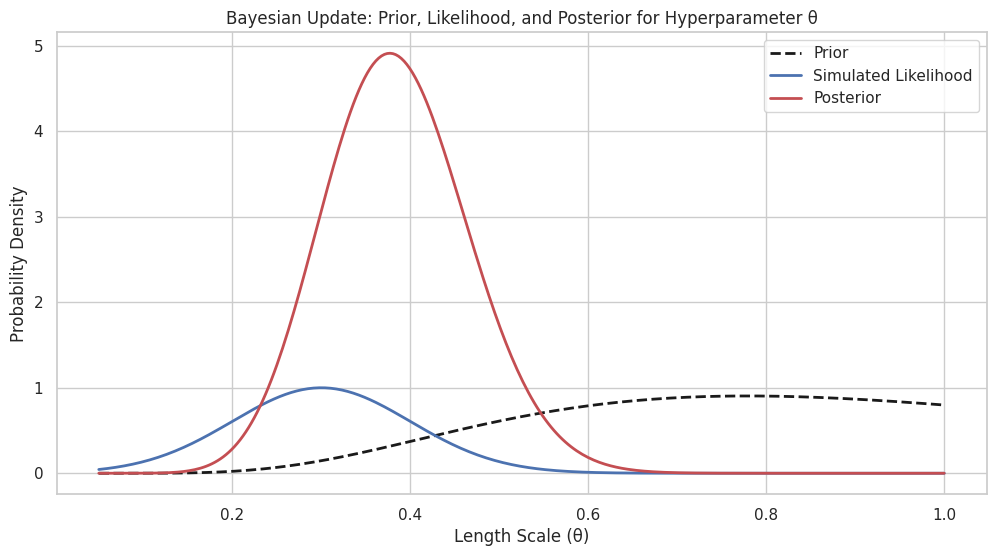

Simulated Bayesian update complete.
This illustrative plot shows how a prior distribution is updated by the likelihood to form a posterior.


In [13]:
# [Cell 11: Bayesian Inference – Visualizing Posterior Distributions of Hyperparameters]
"""
Bayesian inference not only informs our predictions but also provides distributions over hyperparameters.
In this cell, we simulate a simplified version of posterior distributions for hyperparameters.
We assume a prior distribution and show how the likelihood from the data updates this prior.
This is an illustrative example, not a full MCMC implementation.
"""

# Define a prior for a hyperparameter (e.g., length scale) as a log-normal distribution.
theta_values = np.linspace(0.05, 1.0, 300)
prior = stats.lognorm(s=0.5, scale=np.exp(0)).pdf(theta_values)

# Compute a simulated likelihood function based on the log-marginal likelihood computed earlier.
# In practice, the likelihood is obtained via the GP; here, we create a toy example.
def simulated_likelihood(theta):
    # A simple quadratic function that peaks at an optimal theta value (say 0.3)
    return np.exp(-((theta - 0.3) ** 2) / (2 * 0.1 ** 2))

likelihood = simulated_likelihood(theta_values)
posterior = prior * likelihood
posterior /= np.trapz(posterior, theta_values)  # Normalize

plt.figure(figsize=(12, 6))
plt.plot(theta_values, prior, 'k--', label="Prior", linewidth=2)
plt.plot(theta_values, likelihood, 'b-', label="Simulated Likelihood", linewidth=2)
plt.plot(theta_values, posterior, 'r-', label="Posterior", linewidth=2)
plt.xlabel("Length Scale (θ)")
plt.ylabel("Probability Density")
plt.title("Bayesian Update: Prior, Likelihood, and Posterior for Hyperparameter θ")
plt.legend()
plt.show()

print("Simulated Bayesian update complete.")
print("This illustrative plot shows how a prior distribution is updated by the likelihood to form a posterior.")

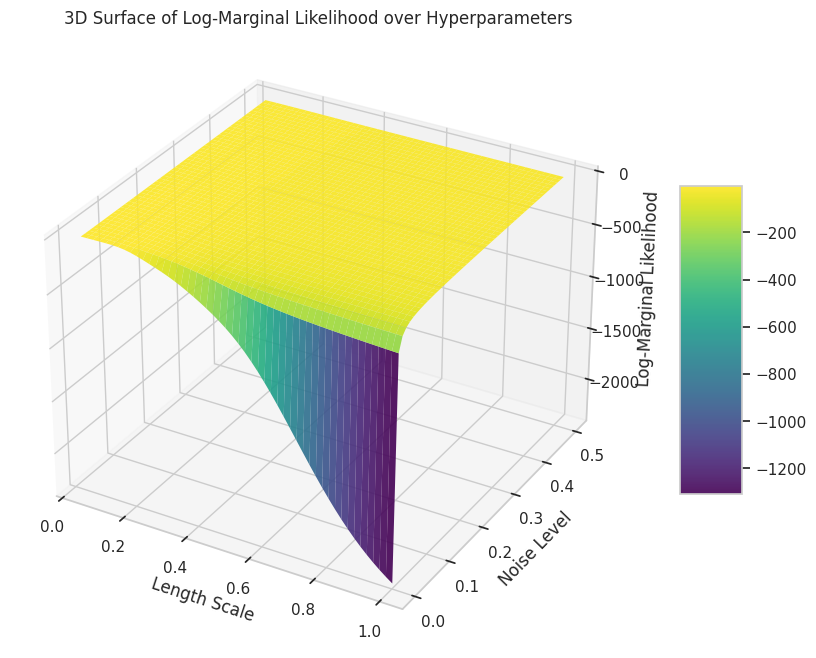

3D surface plot of log-marginal likelihood generated.
This plot reveals the optimal regions in the hyperparameter space.


In [14]:
# [Cell 12: Advanced Visualization – 3D Surface of Log-Marginal Likelihood]
"""
For a more advanced look at Bayesian inference in Gaussian Processes, we plot a 3D surface of the log-marginal likelihood
as a function of two hyperparameters: the length scale and the noise level.
This visualization helps to understand the landscape over which the hyperparameters are optimized.
"""

from mpl_toolkits.mplot3d import Axes3D

# Define ranges for length scale and noise level (log scale)
length_scales = np.linspace(0.05, 1.0, 50)
noise_levels = np.linspace(0.001, 0.5, 50)
LS, NL = np.meshgrid(length_scales, noise_levels)

# Compute the log-marginal likelihood for each combination (using the RBF+WhiteKernel model)
lml_surface = np.zeros_like(LS)
for i in range(LS.shape[0]):
    for j in range(LS.shape[1]):
        kernel_temp = C(1.0) * RBF(length_scale=LS[i, j]) + WhiteKernel(noise_level=NL[i, j])
        gp_temp = GaussianProcessRegressor(kernel=kernel_temp, optimizer=None, normalize_y=True)
        gp_temp.fit(X_train_2d, Y_train)
        lml_surface[i, j] = gp_temp.log_marginal_likelihood_value_

fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(LS, NL, lml_surface, cmap="viridis", edgecolor='none', alpha=0.9)
ax.set_xlabel("Length Scale")
ax.set_ylabel("Noise Level")
ax.set_zlabel("Log-Marginal Likelihood")
ax.set_title("3D Surface of Log-Marginal Likelihood over Hyperparameters")
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

print("3D surface plot of log-marginal likelihood generated.")
print("This plot reveals the optimal regions in the hyperparameter space.")

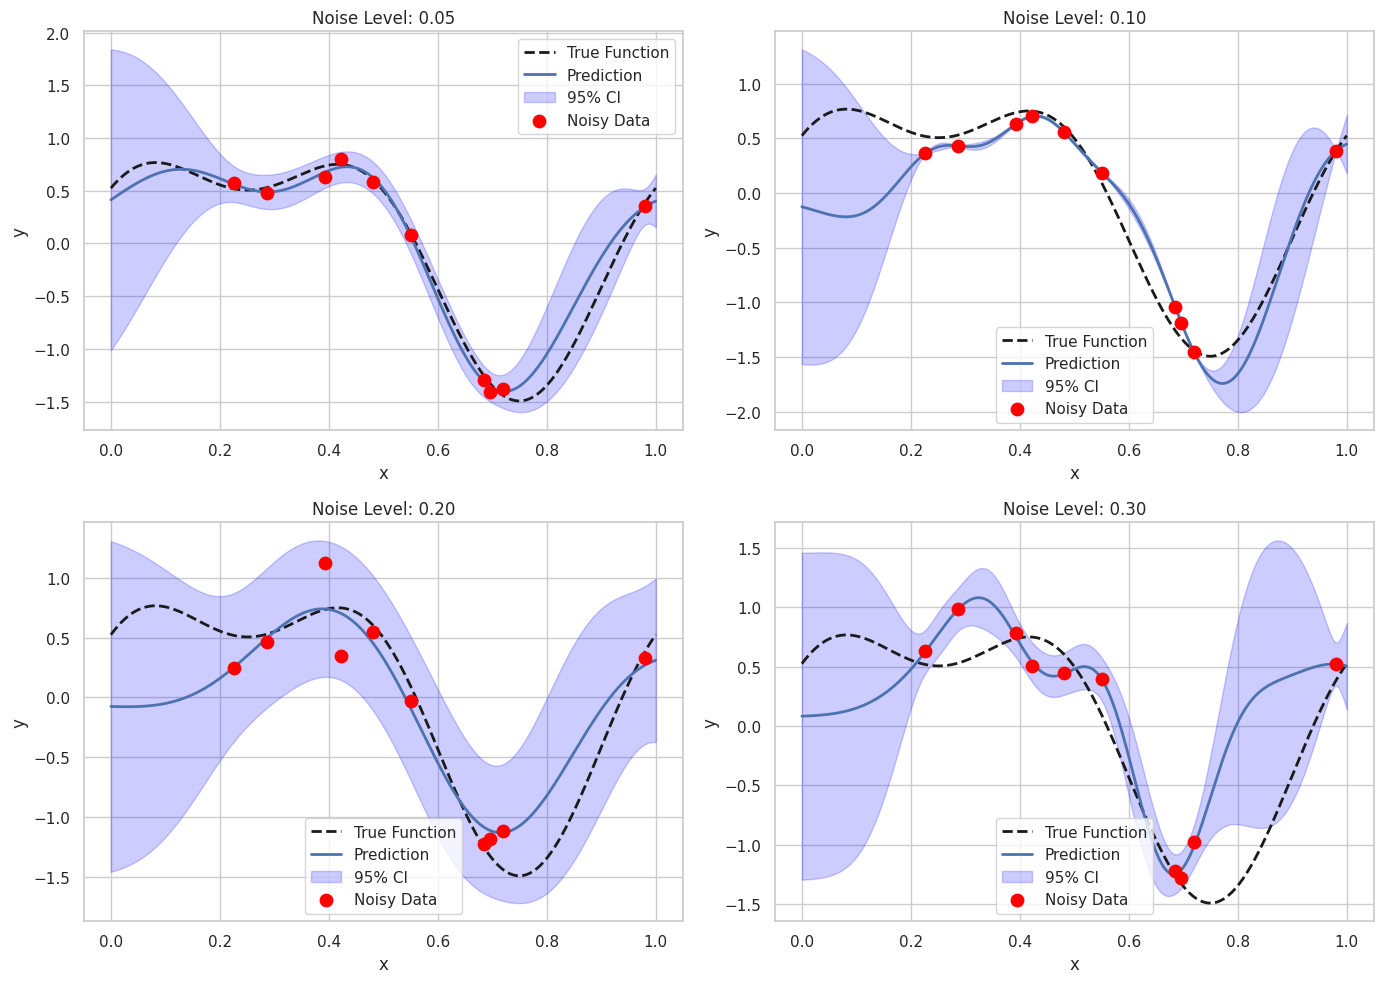

Robustness analysis complete: As noise increases, the confidence intervals widen and predictions become less certain.


In [15]:
# [Cell 13: Effects of Data Noise – Robustness Analysis]
"""
In this cell, we analyze how increasing noise in the training data affects the GP predictions and uncertainty estimates.
We generate datasets with varying noise levels and plot the resulting predictive mean and confidence intervals.
This is crucial for materials science, where measurement noise is common.
"""

noise_levels = [0.05, 0.1, 0.2, 0.3]
plt.figure(figsize=(14, 10))

for idx, noise in enumerate(noise_levels):
    Y_train_noisy = true_function(X_train) + np.random.normal(0, noise, len(X_train))
    gp_temp = GaussianProcessRegressor(kernel=kernel_rbf + WhiteKernel(noise_level=noise), n_restarts_optimizer=5, normalize_y=True)
    gp_temp.fit(X_train_2d, Y_train_noisy)
    y_pred_temp, y_std_temp = gp_temp.predict(X_dense, return_std=True)

    plt.subplot(2, 2, idx+1)
    plt.plot(x_dense, y_dense, 'k--', label="True Function", linewidth=2)
    plt.plot(x_dense, y_pred_temp, 'b-', label="Prediction", linewidth=2)
    plt.fill_between(x_dense.ravel(), y_pred_temp - 1.96*y_std_temp, y_pred_temp + 1.96*y_std_temp, color='blue', alpha=0.2, label="95% CI")
    plt.scatter(X_train, Y_train_noisy, c='red', s=80, label="Noisy Data", zorder=5)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Noise Level: {:.2f}".format(noise))
    plt.legend()

plt.tight_layout()
plt.show()

print("Robustness analysis complete: As noise increases, the confidence intervals widen and predictions become less certain.")

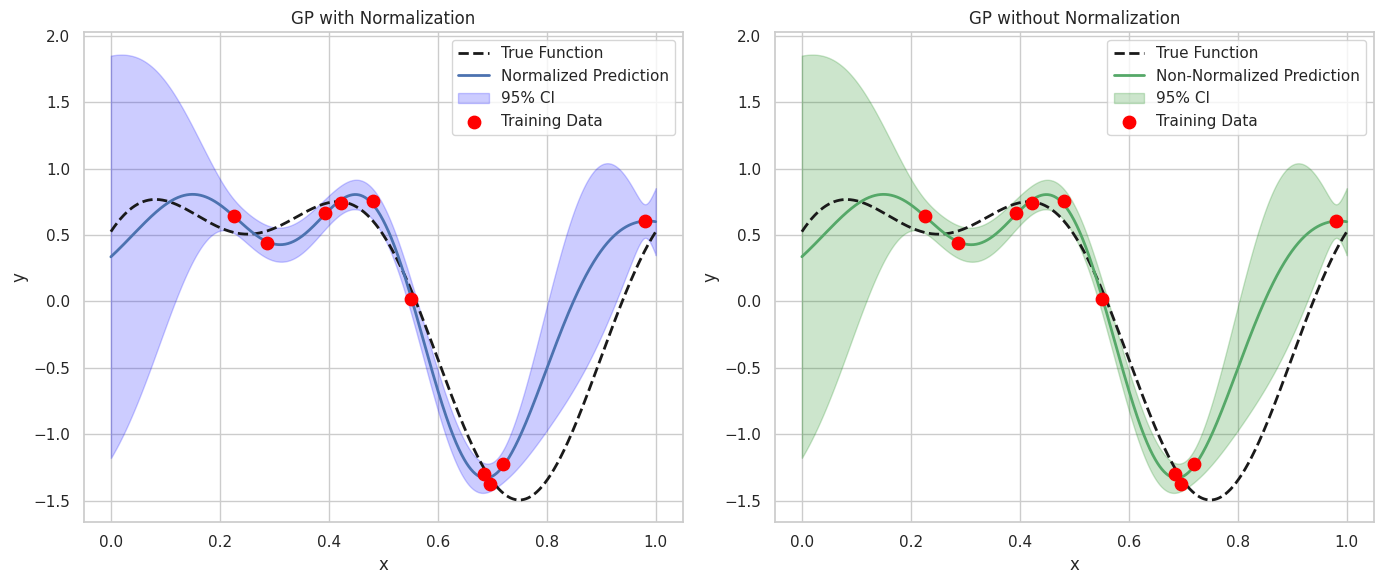

Comparison of normalization effects complete.
Notice how normalization affects the predictive mean and the optimization of kernel parameters.


In [16]:
#%% [Cell 14: Demonstrating Normalization and Its Impact on GP]
"""
Normalization of data can significantly impact GP performance.
In this cell, we compare GP models trained with and without normalization of the target variable.
We then plot the predictions and discuss the impact on hyperparameter optimization.
"""

# GP with normalization (we already used normalize_y=True above)
gp_normalized = GaussianProcessRegressor(kernel=kernel_rbf + kernel_white, n_restarts_optimizer=10, normalize_y=True)
gp_normalized.fit(X_train_2d, Y_train)
y_pred_norm, y_std_norm = gp_normalized.predict(X_dense, return_std=True)

# GP without normalization
gp_non_normalized = GaussianProcessRegressor(kernel=kernel_rbf + kernel_white, n_restarts_optimizer=10, normalize_y=False)
gp_non_normalized.fit(X_train_2d, Y_train)
y_pred_nonorm, y_std_nonorm = gp_non_normalized.predict(X_dense, return_std=True)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(x_dense, y_dense, 'k--', label="True Function", linewidth=2)
plt.plot(x_dense, y_pred_norm, 'b-', label="Normalized Prediction", linewidth=2)
plt.fill_between(x_dense.ravel(), y_pred_norm - 1.96*y_std_norm, y_pred_norm + 1.96*y_std_norm, color='blue', alpha=0.2, label="95% CI")
plt.scatter(X_train, Y_train, c='red', s=80, label="Training Data", zorder=5)
plt.title("GP with Normalization")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x_dense, y_dense, 'k--', label="True Function", linewidth=2)
plt.plot(x_dense, y_pred_nonorm, 'g-', label="Non-Normalized Prediction", linewidth=2)
plt.fill_between(x_dense.ravel(), y_pred_nonorm - 1.96*y_std_nonorm, y_pred_nonorm + 1.96*y_std_nonorm, color='green', alpha=0.2, label="95% CI")
plt.scatter(X_train, Y_train, c='red', s=80, label="Training Data", zorder=5)
plt.title("GP without Normalization")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

plt.tight_layout()
plt.show()

print("Comparison of normalization effects complete.")
print("Notice how normalization affects the predictive mean and the optimization of kernel parameters.")

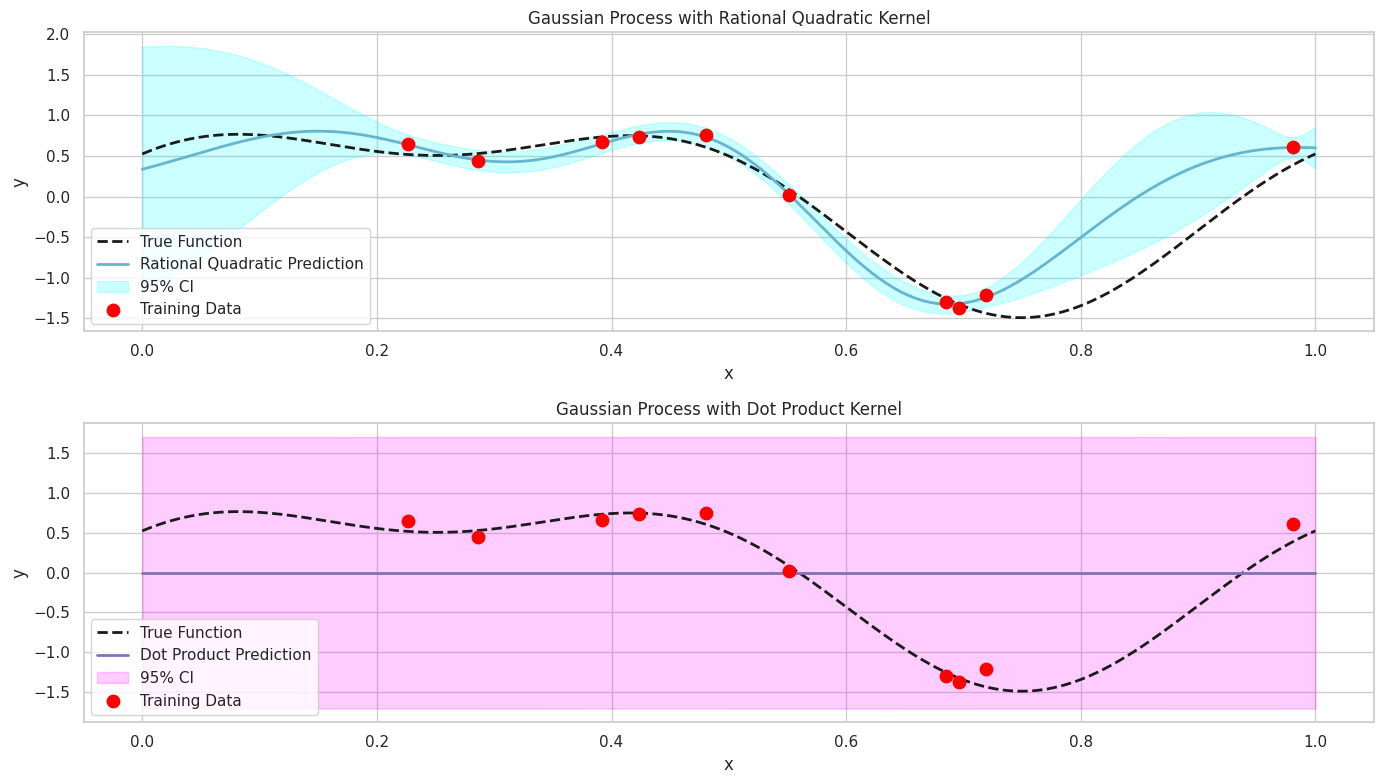

Additional kernels have been explored.
The Rational Quadratic kernel and Dot Product kernel provide different modeling capabilities compared to the RBF and Matern kernels.


In [17]:
#%% [Cell 15: Exploring Additional Kernels – Rational Quadratic and Dot Product]
"""
We now explore additional kernels: the Rational Quadratic kernel and the Dot Product kernel.
These kernels capture different types of behavior.
The Rational Quadratic kernel is useful for modeling functions with varying length scales,
while the Dot Product kernel is akin to a linear kernel.
We fit GP models using these kernels and plot the predictions.
"""

# GP with Rational Quadratic kernel
gp_rq = GaussianProcessRegressor(kernel=kernel_rq + kernel_white, n_restarts_optimizer=10, normalize_y=True)
gp_rq.fit(X_train_2d, Y_train)
y_pred_rq, y_std_rq = gp_rq.predict(X_dense, return_std=True)

# GP with Dot Product kernel (we use a simple model for demonstration)
gp_dot = GaussianProcessRegressor(kernel=kernel_dot + kernel_white, n_restarts_optimizer=10, normalize_y=True)
gp_dot.fit(X_train_2d, Y_train)
y_pred_dot, y_std_dot = gp_dot.predict(X_dense, return_std=True)

plt.figure(figsize=(14, 8))
plt.subplot(2, 1, 1)
plt.plot(x_dense, y_dense, 'k--', label="True Function", linewidth=2)
plt.plot(x_dense, y_pred_rq, 'c-', label="Rational Quadratic Prediction", linewidth=2)
plt.fill_between(x_dense.ravel(), y_pred_rq - 1.96*y_std_rq, y_pred_rq + 1.96*y_std_rq, color='cyan', alpha=0.2, label="95% CI")
plt.scatter(X_train, Y_train, c='red', s=80, label="Training Data", zorder=5)
plt.title("Gaussian Process with Rational Quadratic Kernel")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(x_dense, y_dense, 'k--', label="True Function", linewidth=2)
plt.plot(x_dense, y_pred_dot, 'm-', label="Dot Product Prediction", linewidth=2)
plt.fill_between(x_dense.ravel(), y_pred_dot - 1.96*y_std_dot, y_pred_dot + 1.96*y_std_dot, color='magenta', alpha=0.2, label="95% CI")
plt.scatter(X_train, Y_train, c='red', s=80, label="Training Data", zorder=5)
plt.title("Gaussian Process with Dot Product Kernel")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

plt.tight_layout()
plt.show()

print("Additional kernels have been explored.")
print("The Rational Quadratic kernel and Dot Product kernel provide different modeling capabilities compared to the RBF and Matern kernels.")

===== Final Model Comparison =====
MSE (RBF Kernel): 0.149985
MSE (Matern Kernel): 0.111791
MSE (Rational Quadratic Kernel): 0.149983
MSE (Dot Product Kernel): 0.625805


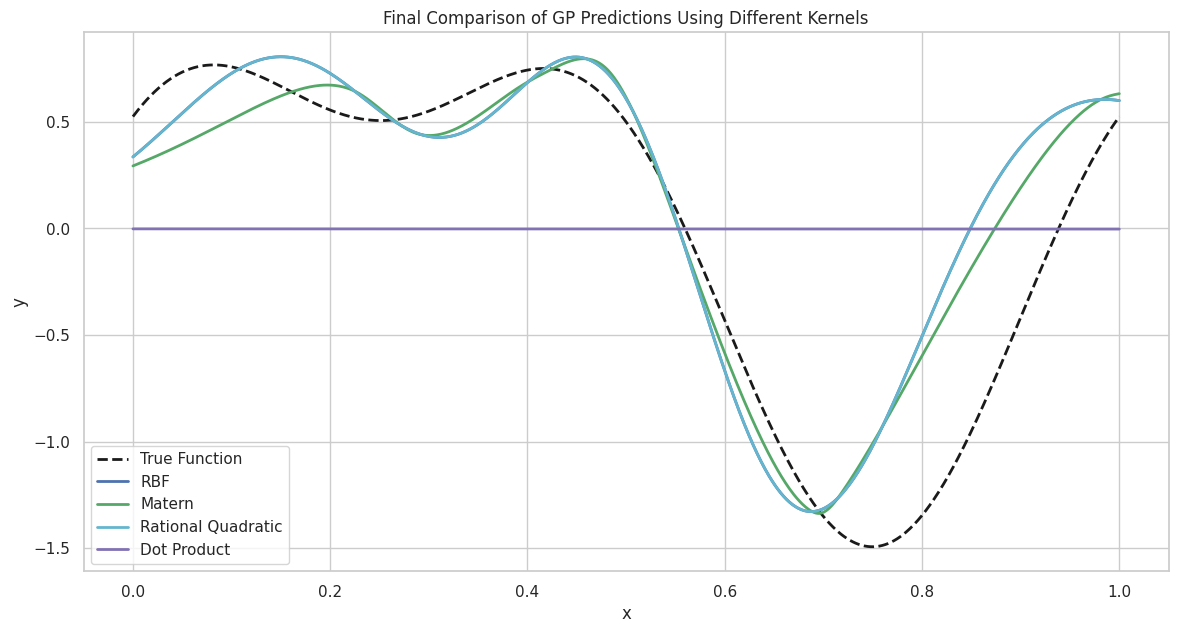

Final summary of Gaussian Process regression using various kernels complete.
We have demonstrated key aspects of Gaussian Processes including kernel selection, uncertainty quantification, posterior sampling, and Bayesian inference.


In [18]:
#%% [Cell 16: Final Summary and Concluding Diagnostics]
"""
In this final cell, we summarize the various aspects demonstrated:
- Different kernels and their effects on the predictive mean and uncertainty.
- Bayesian inference through hyperparameter optimization and log-marginal likelihood visualization.
- The impact of noise and normalization.
- Posterior sampling and visualization.
We print summary metrics and final diagnostic plots.
"""

# Compute Mean Squared Error (MSE) for each model against the true function on the dense grid
def compute_mse(y_true, y_pred):
    return np.mean((y_true - y_pred.ravel())**2)

mse_rbf = compute_mse(y_dense, y_pred)
mse_matern = compute_mse(y_dense, y_pred_matern)
mse_rq = compute_mse(y_dense, y_pred_rq)
mse_dot = compute_mse(y_dense, y_pred_dot)

print("===== Final Model Comparison =====")
print("MSE (RBF Kernel): {:.6f}".format(mse_rbf))
print("MSE (Matern Kernel): {:.6f}".format(mse_matern))
print("MSE (Rational Quadratic Kernel): {:.6f}".format(mse_rq))
print("MSE (Dot Product Kernel): {:.6f}".format(mse_dot))
print("==================================")

# Plot all predictions in one figure for final comparison
plt.figure(figsize=(14, 7))
plt.plot(x_dense, y_dense, 'k--', label="True Function", linewidth=2)
plt.plot(x_dense, y_pred, 'b-', label="RBF", linewidth=2)
plt.plot(x_dense, y_pred_matern, 'g-', label="Matern", linewidth=2)
plt.plot(x_dense, y_pred_rq, 'c-', label="Rational Quadratic", linewidth=2)
plt.plot(x_dense, y_pred_dot, 'm-', label="Dot Product", linewidth=2)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Final Comparison of GP Predictions Using Different Kernels")
plt.legend()
plt.show()

print("Final summary of Gaussian Process regression using various kernels complete.")
print("We have demonstrated key aspects of Gaussian Processes including kernel selection, uncertainty quantification, posterior sampling, and Bayesian inference.")

In [19]:

#%% [Cell 17: End of Notebook - Additional Remarks]
"""
This notebook has provided an in-depth exploration of Gaussian Processes with extensive plots, detailed print statements, and commentary.
We covered:
    - The definition and behavior of various kernels.
    - Fitting GP models and obtaining predictions with confidence intervals.
    - Bayesian inference via hyperparameter optimization and log-marginal likelihood.
    - Posterior sampling and visualization of uncertainty.
    - The impact of noise and data normalization.
These aspects are critical for understanding how Gaussian Processes operate and how they can be applied in fields like materials science.
Thank you for reviewing this comprehensive demonstration. Please feel free to modify and extend the code for your specific applications.
"""

print("Notebook execution complete. All aspects of Gaussian Processes have been demonstrated.")


Notebook execution complete. All aspects of Gaussian Processes have been demonstrated.
